# LIME

We have installed lime-0.2.0.1 (pip install lime) and ipywidgets-7.6.5 jupyterlab-widgets-1.0.2 widgetsnbextension-3.5.1 (pip install ipywidgets).

In [1]:
import os
import json

import numpy as np
import matplotlib.pylab as plt
from tensorflow.keras.models import load_model

from imgclas import paths, utils, data_utils
from imgclas.data_utils import load_data_splits, load_class_names, k_crop_data_sequence
from imgclas.test_utils import predict
from imgclas.visualization.saliency import GradientSaliency
from imgclas.visualization.guided_backprop import GuidedBackprop
from imgclas.visualization.integrated_gradients import IntegratedGradients
from imgclas.visualization.visual_backprop import VisualBackprop

# User parameters to set
TIMESTAMP = '2021-09-28_Lab_Madrid_CopaBor_FondoBlanco_Xception_100ep'                       # timestamp of the model
MODEL_NAME = 'final_model.h5'                           # model to use to make the prediction
TOP_K = 2                                               # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load the data
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load training configuration
conf_path = os.path.join(paths.get_conf_dir(), 'conf.json')
with open(conf_path) as f:
    conf = json.load(f)
    
# Load the model
model = load_model(os.path.join(paths.get_checkpoints_dir(), MODEL_NAME), custom_objects=utils.get_custom_objects(), compile=False)

W0929 10:15:26.348841 140064475002688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 10:15:26.350983 140064475002688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0929 10:15:26.352843 140064475002688 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtyp

Loading class names...


In [35]:
# FILEPATH = '/srv/image-classification-tf/data/images/Est_Mad_J_Bor_100_nd_f_bl_con_al_inf.jpg'
FILEPATH = '/srv/image-classification-tf/data/images/Est_Mad_J_Bor_75_nd_f_bl_con_ce_inf.jpg'

# # Load the image and preprocess it for the lime computation
# data_gen = k_crop_data_sequence(inputs=[FILEPATH],
#                                 im_size=conf['model']['image_size'],
#                                 mean_RGB=conf['dataset']['mean_RGB'],
#                                 std_RGB=conf['dataset']['std_RGB'],
#                                 preprocess_mode=conf['model']['preprocess_mode'],
#                                 aug_params=None,
#                                 crop_mode='random',
#                                 crop_number=1)#,
#                                 #filemode='local')

# img_arr = data_gen.__getitem__(0)
# img_arr = img_arr.squeeze(axis=0)

# Original image
image = data_utils.load_image(FILEPATH)#, filemode='local')
image = data_utils.resize_im(image, height=conf['model']['image_size'], width=conf['model']['image_size'])

In [41]:
# https://colab.research.google.com/github/arteagac/arteagac.github.io/blob/master/blog/lime_image.ipynb#scrollTo=JvUcphNbZEWI
# Step 1. Create perturbations of image
superpixels = skimage.segmentation.quickshift(image, kernel_size=4,max_dist=200, ratio=0.2)
num_superpixels = np.unique(superpixels).shape[0]
num_superpixels

196

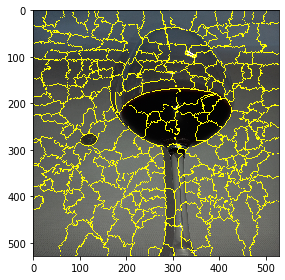

In [50]:
import skimage.io 
import skimage.segmentation
import copy
skimage.io.imshow(skimage.segmentation.mark_boundaries(image, superpixels))

In [52]:
num_perturb = 150
perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
perturbations[0] #Show example of perturbation

array([0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1,
       1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1])

In [53]:
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image

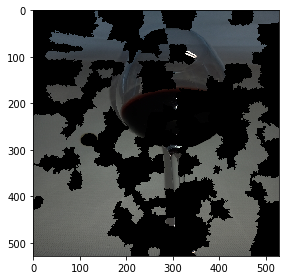

In [65]:
skimage.io.imshow(perturb_image(np.clip(image/np.amax(image), 0, 255),perturbations[0],superpixels))

In [86]:
perturbed_img.shape

(528, 528, 3)

In [90]:
conf['dataset']

{'mean_RGB': [145.7009020327461, 145.57541800835594, 143.40409009710942],
 'std_RGB': [37.09825214810984, 38.16266727994038, 37.706027031863435]}

In [93]:
from imgclas.data_utils import preprocess_batch, resize_im

batch_X = []

im_aug = resize_im(np.copy(perturbed_img), height=224, width=224)
batch_X.append(im_aug)  # shape (N, 224, 224, 3)

batch_X = preprocess_batch(batch=batch_X, mean_RGB=conf['dataset']['mean_RGB'], std_RGB=conf['dataset']['std_RGB'], mode=conf['model']['preprocess_mode'])

In [101]:
from imgclas.data_utils import data_generator
data_gen=data_generator(inputs=batch_X, targets=100, batch_size=16, mean_RGB=conf['dataset']['mean_RGB'], std_RGB=conf['dataset']['std_RGB'], preprocess_mode=conf['model']['preprocess_mode'], aug_params={}, num_classes=6)

In [95]:
batch_X.shape

(1, 224, 224, 3)

In [107]:
pred = model.predict(data_gen, verbose=1)

ValueError: Please specify the number of steps via the `steps` argument.

In [72]:
predictions = []
for pert in perturbations:
    perturbed_img = perturb_image(image,pert,superpixels)
    pred = model.predict(batch_X,
                           verbose=1,
                           max_queue_size=10,
                           workers=4,
                           use_multiprocessing=True)
    predictions.append(pred)

predictions = np.array(predictions)
predictions.shape

ValueError: Error when checking input: expected input_1 to have 4 dimensions, but got array with shape (528, 528, 3)

El paquete LIME no da buenos resultados:

In [37]:
from lime import lime_image
from imgclas.data_utils import load_image, load_data_splits, load_class_names

explainer = lime_image.LimeImageExplainer()


explanation = explainer.explain_instance(image, 
                                model.predict,
                                top_labels=3, hide_color=0, batch_size=16, num_samples=1000)

  0%|          | 0/1000 [00:00<?, ?it/s]

In [20]:
?explainer.explain_instance

Signature:
explainer.explain_instance(
    image,
    classifier_fn,
    labels=(1,),
    hide_color=None,
    top_labels=5,
    num_features=100000,
    num_samples=1000,
    batch_size=10,
    segmentation_fn=None,
    distance_metric='cosine',
    model_regressor=None,
    random_seed=None,
)
Docstring:
Generates explanations for a prediction.

First, we generate neighborhood data by randomly perturbing features
from the instance (see __data_inverse). We then learn locally weighted
linear models on this neighborhood data to explain each of the classes
in an interpretable way (see lime_base.py).

Args:
    image: 3 dimension RGB image. If this is only two dimensional,
        we will assume it's a grayscale image and call gray2rgb.
    classifier_fn: classifier prediction probability function, which
        takes a numpy array and outputs prediction probabilities.  For
        ScikitClassifiers , this is classifier.predict_proba.
    labels: iterable with labels to be explained.
    

(-0.5, 527.5, 527.5, -0.5)

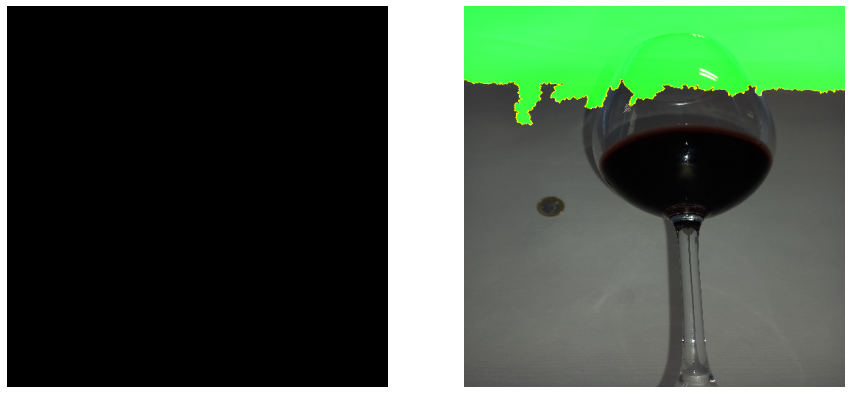

In [39]:
from skimage.segmentation import mark_boundaries

temp_1, mask_1 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=20, hide_rest=True)
temp_2, mask_2 = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=50, hide_rest=False)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
ax1.imshow(mark_boundaries(temp_1, mask_1))
ax2.imshow(mark_boundaries(temp_2, mask_2))
ax1.axis('off')
ax2.axis('off')

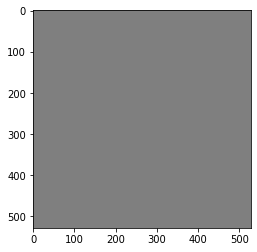

In [28]:
import skimage
temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True)
plt.imshow(skimage.segmentation.mark_boundaries(temp / 2 + 0.5, mask))

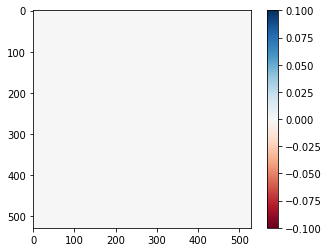

In [29]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]
#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 
#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

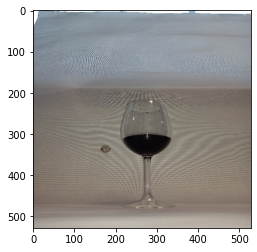

In [30]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
img_boundry1 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry1)

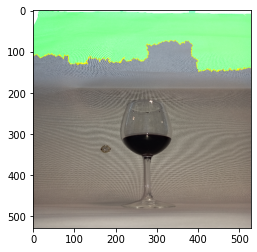

In [34]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=25, hide_rest=False)
img_boundry2 = mark_boundaries(temp/255.0, mask)
plt.imshow(img_boundry2)